# Decision Tree Modeling

# Importing Necessary Libraries

In [1]:
# Install gitpath below if not already available on your environment.
#! pip install git+https://github.com/maxnoe/python-gitpath
import gitpath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Importing the Data

In [2]:
#Getting the file path for the data file.
file_path = str(gitpath.root()) + '/data/no_nans_data.xlsx'

In [3]:
df = pd.read_excel(file_path)
df['Contract Years Left'] = df['Contract Years Left'].apply(lambda x:int(x))

# Separating Data by Position

In [4]:
attack = df[df['Position']=='attack']
midfield = df[df['Position']=='midfield']
defence = df[df['Position']=='Defender']

# Decision Trees Regressor with all Features and Default Hyperparameters

### We will first build a modeling workflow on the Attackers dataset

In [5]:
X = attack.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = attack['Value']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [7]:
#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)


#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

In [8]:
#Initiating DecisionTreeRegressor to calculate feature importance
DtReg = DecisionTreeRegressor()

In [9]:
DtReg.fit(X_train_scaled,y_train);

In [10]:
cross_val_train = cross_val_score(DtReg, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(DtReg, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)




In [11]:
#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

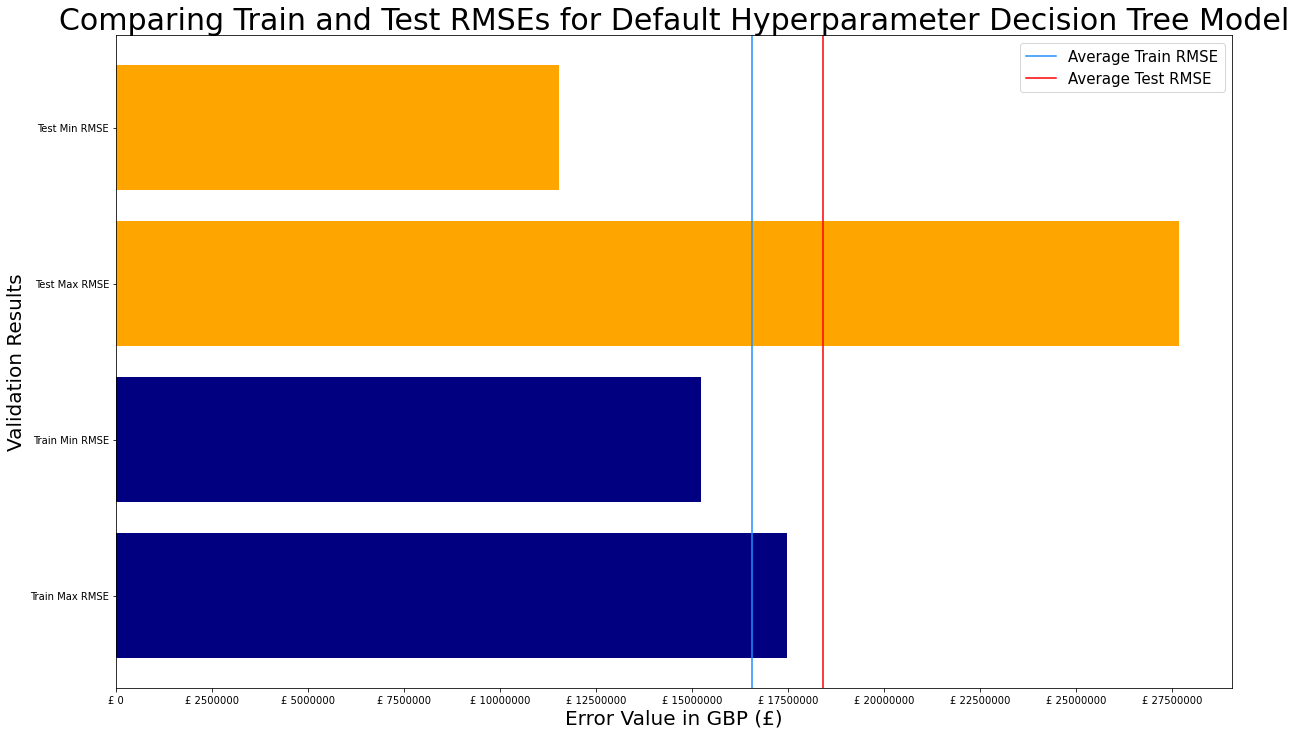

In [12]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,max([results.iloc[0][2],(round(results.iloc[1][2])+1000000)]),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Comparing Train and Test RMSEs for Default Hyperparameter Decision Tree Model',fontsize=30)
ax.legend(fontsize=15);

# Hyperparameter Tuning. (Finding  Hyperparameters that may improve our model performance)

Since a GridSearch would take a long time to run with all our features, we will perform a GridSearch for a model that would only take the top 10 most important features.

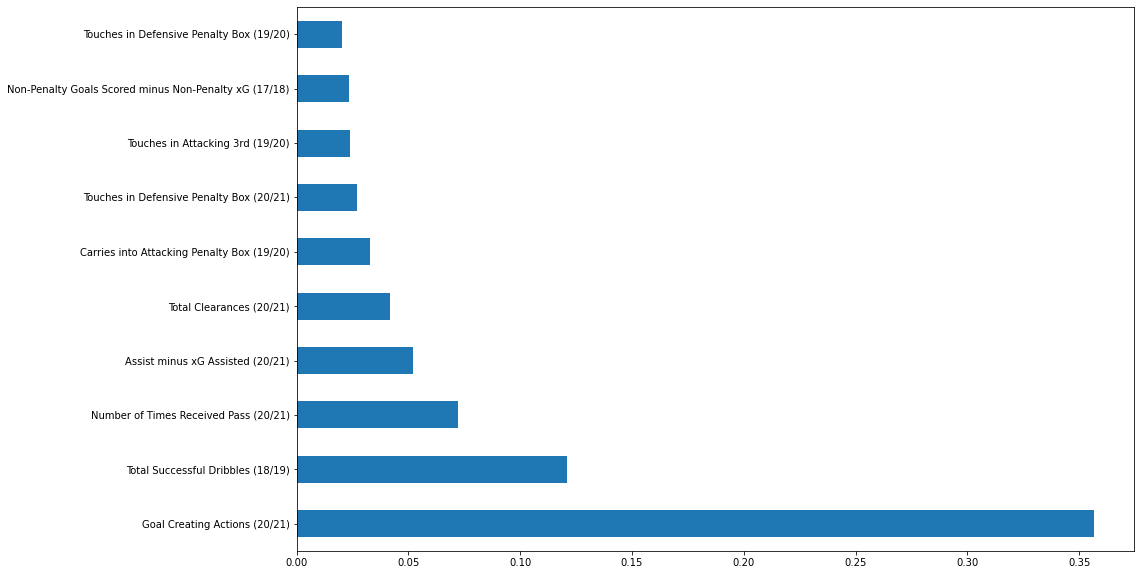

In [13]:
# print the features importance.

fig,ax = plt.subplots(figsize=(15,10))

feat_importances = pd.Series(DtReg.feature_importances_, index=X_train.columns)

feat_importances.nlargest(10).plot(kind='barh')

plt.show()

In [14]:
#Creating a list of top features
top_features = list(feat_importances.nlargest(10).keys())

## Building a newer model. This time only with important features

In [15]:
X = attack.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = attack['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [16]:
#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

## Grid Search

In [17]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

tuning_model=GridSearchCV(DtReg,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=5,verbose=5)

#function for calculating how much time taken for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

### Fitting data to find best parameters

In [18]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X_train_scaled,y_train)

timer(start_time)

In [19]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 11,
 'max_features': 'log2',
 'max_leaf_nodes': 40,
 'min_samples_leaf': 9,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

# Using a Decision Tree Regressor with important features and better Parameters

In [20]:
param_values = list((tuning_model.best_params_).values())

In [21]:
# Traning model with all features using best Decision Tree Hyperparameters

DtReg_Grid = DecisionTreeRegressor(max_depth=param_values[0],
                                 max_features=param_values[1],
                                 max_leaf_nodes=param_values[2],
                                 min_samples_leaf=param_values[3],
                                 min_weight_fraction_leaf=param_values[4],
                                 splitter=param_values[5])

DtReg_Grid.fit(X_train_scaled,y_train);

In [22]:
cross_val_train = cross_val_score(DtReg_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(DtReg_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

In [23]:
#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_att = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_att.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_att.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

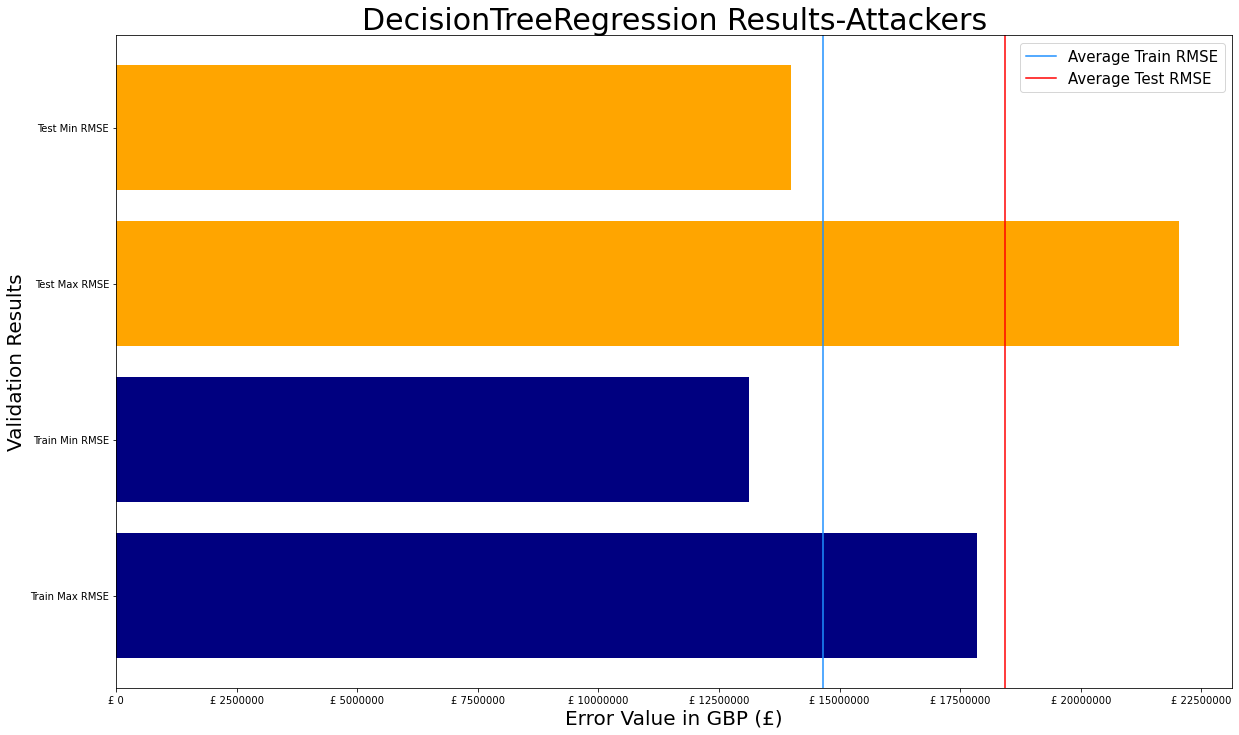

In [24]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,max([results_att.iloc[0][2],(round(results_att.iloc[1][2])+1000000)]),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_att.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_att.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_att.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_att.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_att.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_att.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('DecisionTreeRegression Results-Attackers',fontsize=30)
ax.legend(fontsize=15);

# Applying the above workflow for Midfielders

In [25]:
%%capture
#Splitting the data

X = midfield.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = midfield['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#Fitting data into first DecisionTree to get important features

#Initiating DecisionTreeRegressor
DtReg = DecisionTreeRegressor()

DtReg.fit(X_train_scaled,y_train);

############################################################################

#Extracting Most Important Features

feat_importances = pd.Series(DtReg.feature_importances_, index=X_train.columns)

#Creating a list of top features
top_features = list(feat_importances.nlargest(10).keys())

############################################################################

#Repeating Workflow. This time only with most important features.

#This is because of computational constraints from GridSearching over 500 features.

X = midfield.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = midfield['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)


############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#GridSearching improved hyperparameters

# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

tuning_model=GridSearchCV(DtReg,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=5,verbose=5)

tuning_model.fit(X_train_scaled,y_train)


#Extracting the best Parameters
param_values = list((tuning_model.best_params_).values())

############################################################################
        
# Traning model with all features using better Decision Tree Hyperparameters

#Initiating a new DecisionTreeRegressor
DtReg_Grid = DecisionTreeRegressor(max_depth=param_values[0],
                                 max_features=param_values[1],
                                 max_leaf_nodes=param_values[2],
                                 min_samples_leaf=param_values[3],
                                 min_weight_fraction_leaf=param_values[4],
                                 splitter=param_values[5])

DtReg_Grid.fit(X_train_scaled,y_train);

cross_val_train = cross_val_score(DtReg_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(DtReg_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_mid = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_mid.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_mid.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

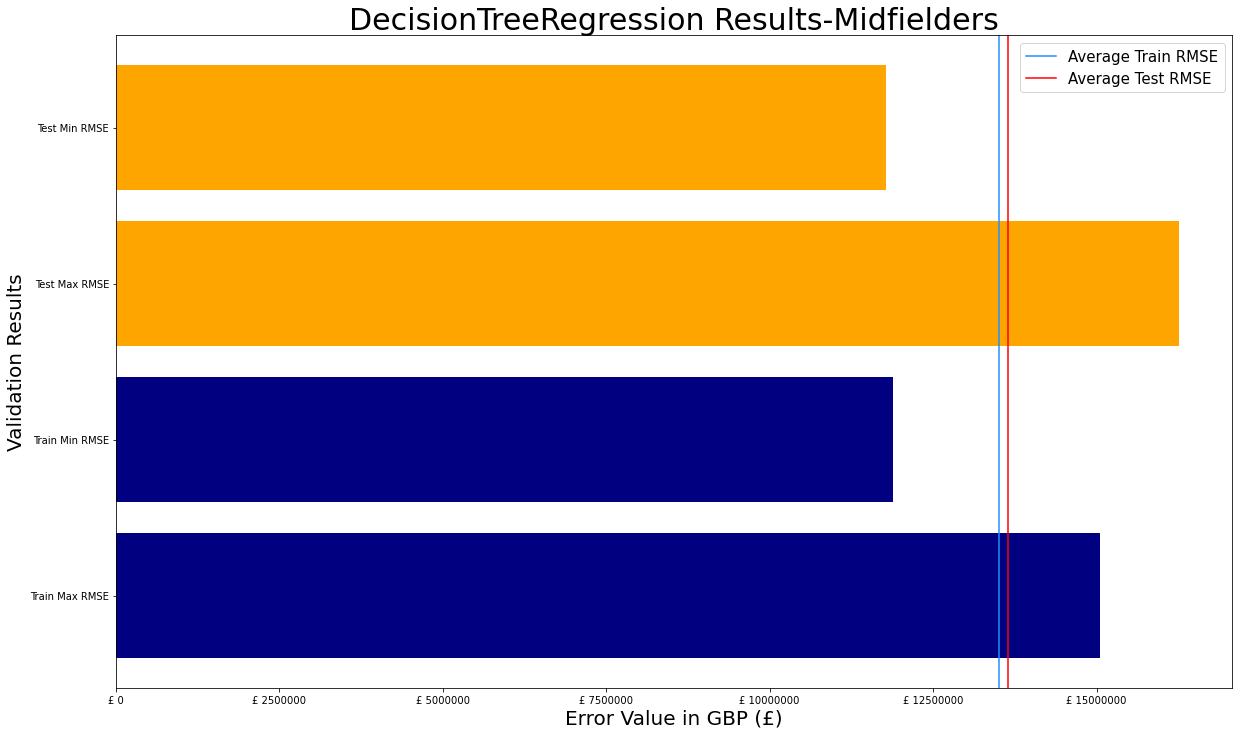

In [26]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,max([results_mid.iloc[0][2],(round(results_mid.iloc[1][2])+1000000)]),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_mid.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_mid.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_mid.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_mid.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_mid.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_mid.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('DecisionTreeRegression Results-Midfielders',fontsize=30)
ax.legend(fontsize=15);

# Applying the above workflow for Defenders

In [27]:
%%capture
#Splitting the data

X = defence.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = defence['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#Fitting data into first DecisionTree to get important features

#Initiating DecisionTreeRegressor
DtReg = DecisionTreeRegressor()

DtReg.fit(X_train_scaled,y_train);

############################################################################

#Extracting Most Important Features

feat_importances = pd.Series(DtReg.feature_importances_, index=X_train.columns)

#Creating a list of top features
top_features = list(feat_importances.nlargest(10).keys())

############################################################################

#Repeating Workflow. This time only with most important features.

#This is because of computational constraints from GridSearching over 500 features.

X = defence.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = defence['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)


############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#GridSearching improved hyperparameters

# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

tuning_model=GridSearchCV(DtReg,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=5,verbose=3)

tuning_model.fit(X_train_scaled,y_train)


#Extracting the best Parameters
param_values = list((tuning_model.best_params_).values())

############################################################################
        
# Traning model with all features using better Decision Tree Hyperparameters

#Initiating a new DecisionTreeRegressor
DtReg_Grid = DecisionTreeRegressor(max_depth=param_values[0],
                                 max_features=param_values[1],
                                 max_leaf_nodes=param_values[2],
                                 min_samples_leaf=param_values[3],
                                 min_weight_fraction_leaf=param_values[4],
                                 splitter=param_values[5])

DtReg_Grid.fit(X_train_scaled,y_train);

cross_val_train = cross_val_score(DtReg_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(DtReg_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_def = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_def.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_def.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

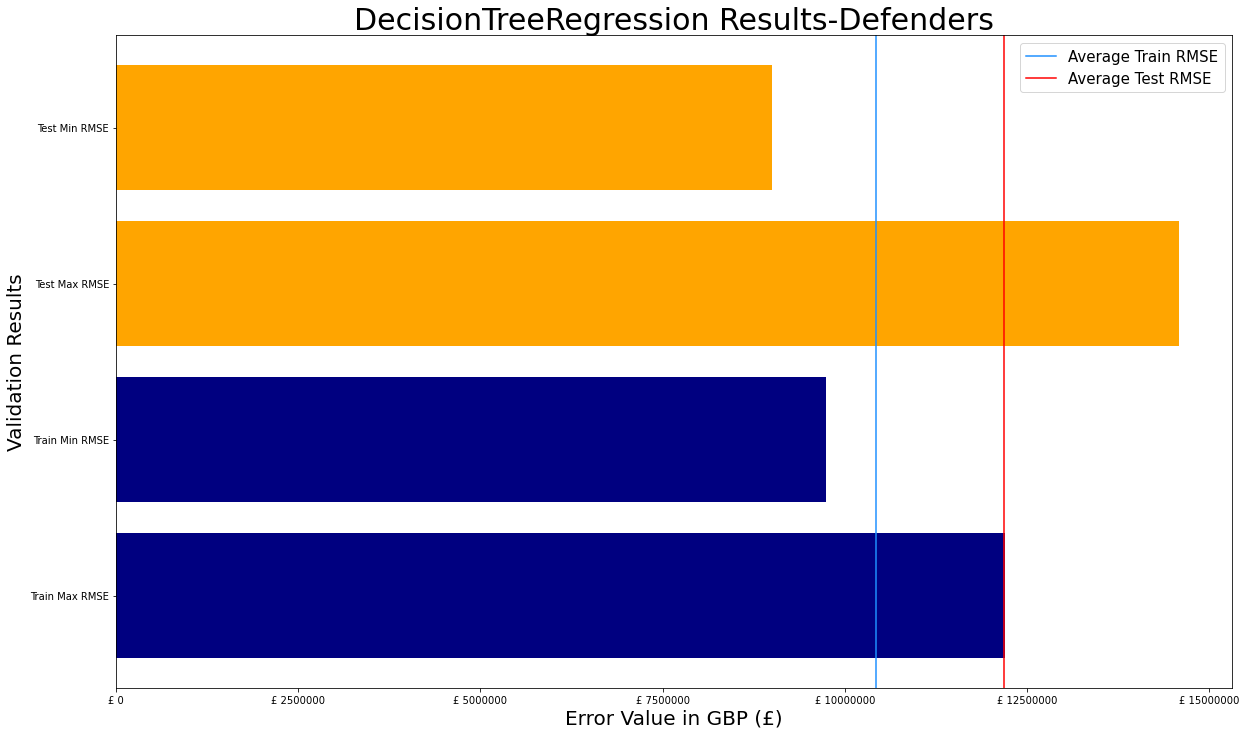

In [28]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,max([results_def.iloc[0][2],(round(results_def.iloc[1][2])+1000000)]),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_def.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_def.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_def.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_def.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_def.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_def.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('DecisionTreeRegression Results-Defenders',fontsize=30)
ax.legend(fontsize=15);

# Comparing Model Performance for all three Positions

### Attackers

In [29]:
results_att

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,14645838.77,17853648.07,13111885.01
1,Test,18420271.01,22033897.38,13987068.28


### Midfielders

In [30]:
results_mid

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,13509705.19,15052857.95,11881107.24
1,Test,13637991.79,16259954.48,11782082.80


### Defenders

In [31]:
results_def

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,10424269.55,12191782.81,9745567.61
1,Test,12187829.81,14583295.48,9000880.77


## Visualizing RMSEs together

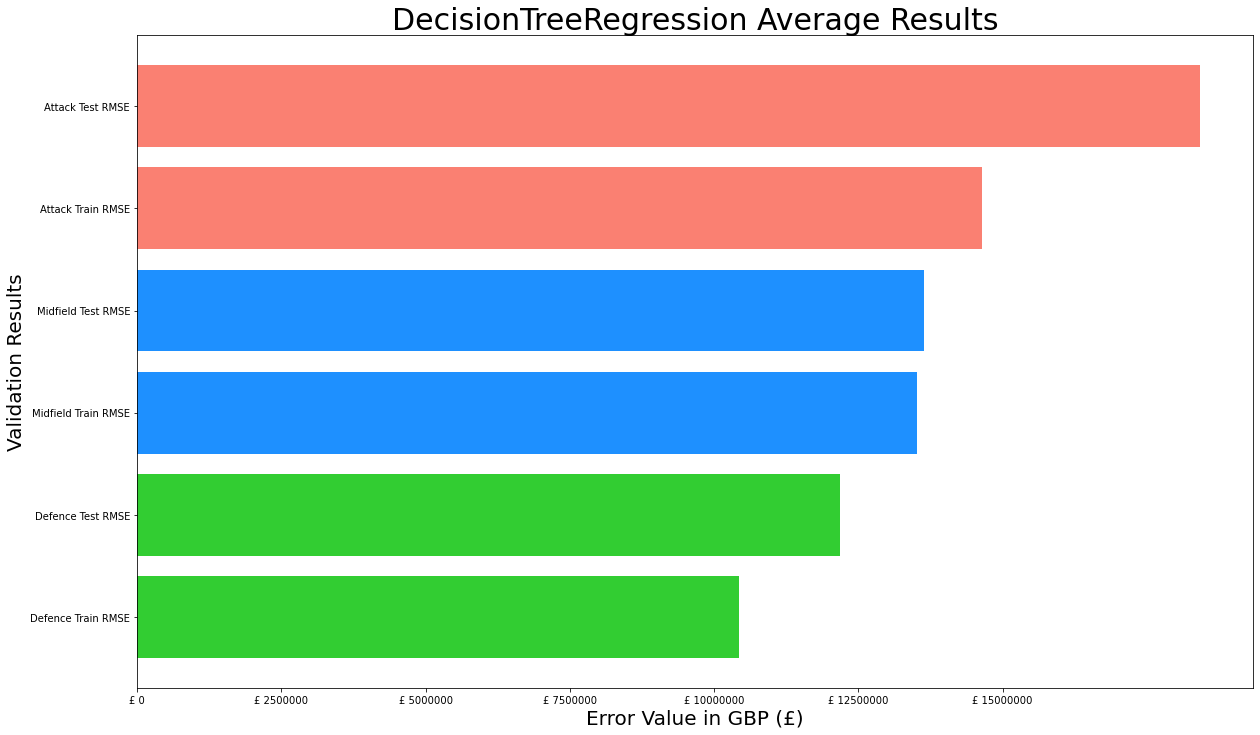

In [32]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,int(max([max(results_att['Avg RMSE']),max(results_mid['Avg RMSE']),max(results_def['Avg RMSE'])])+1000000),2500000))
y_ticks = [1,2,3,4,5,6]
y_ticks = [1,2,3,4,5,6]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Attack Train RMSE','Attack Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = results_def.iloc[0][1]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = results_def.iloc[1][1]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = results_mid.iloc[0][1]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = results_mid.iloc[1][1]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Attack Results
att_train_pos = 5
att_train = results_att.iloc[0][1]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = results_att.iloc[1][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('DecisionTreeRegression Average Results',fontsize=30);